<a href="https://colab.research.google.com/github/xbadiam/Forecasting_weather_with_LSTM/blob/main/notebooks/Forecasting_weather_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Context





### 1.1. El set de datos




### 1.2. Problema a resolver

Desarrollo de modelos predictivos basados en redes neuronales LSTM usando los enfoques:

1. Univariado + single-step
2. Univariado + multi-step
3. Multivariado + single-step
4. Multivariado + multi-step


### 1.3. Descipción de los datos

- *p (mbar)*: presión del aire en milibars
- *T (degC)*: temperatura del aire en °C
- *Tpot (K)*: temperatura potencial
- *Tdew (degC)*: temperatura de punto de rocío (a la cual el vapor de agua se condensa)
- *rh (%)*: humedad relativa
- *VPmax (mbar)*: presión de vapor de agua de saturación
- *VPact (mbar)*: presión de vapor de agua real
- *VPdef (mbar)*: déficit de presión de vapor de agua
- *sh (g/kg)*: humedad específica
- *H2OC (mmol/mol)*: nivel de concentración del vapor de agua
- *rho (g/m**3)*: densidad del aire
- *wv (m/s)*: velocidad del viento
- *max. wv (m/s)*: velocidad del viento máxima
- *wd (deg)*: dirección del viento


Disponemos dos tipos de variables al momento de implementar los modelos LSTM:

- Variable a predecir: la variable a pronosticar (salida del modelo LSTM). En este caso es *T (degC)*
- Variables predictoras (o covariables): las variables de entrada al modelo LSTM a partir de las cuales se realizará la predicción.
  - Puede incluir la variable a predecir (*T (degC)*)
  - Puede incluir la variable tiempo (columna *datetime*)

## 2. Imports

In [82]:
!rm -rf /content/Forecasting_weather_with_LSTM

! git clone https://github.com/xbadiam/Forecasting_weather_with_LSTM.git

Cloning into 'Forecasting_weather_with_LSTM'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 31 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 2.07 MiB | 8.71 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [83]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt


## 3. Load data

In [84]:
data = pd.read_csv('/content/Forecasting_weather_with_LSTM/inputs/weather_dataset.csv')


In [85]:
data.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [86]:
data.shape

(50278, 15)

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50278 entries, 0 to 50277
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date Time        50278 non-null  object 
 1   p (mbar)         50278 non-null  float64
 2   T (degC)         50278 non-null  float64
 3   Tpot (K)         50278 non-null  float64
 4   Tdew (degC)      50278 non-null  float64
 5   rh (%)           50278 non-null  float64
 6   VPmax (mbar)     50270 non-null  float64
 7   VPact (mbar)     50278 non-null  float64
 8   VPdef (mbar)     50278 non-null  float64
 9   sh (g/kg)        50278 non-null  float64
 10  H2OC (mmol/mol)  50265 non-null  float64
 11  rho (g/m**3)     50272 non-null  float64
 12  wv (m/s)         50278 non-null  float64
 13  max. wv (m/s)    50278 non-null  float64
 14  wd (deg)         50278 non-null  float64
dtypes: float64(14), object(1)
memory usage: 5.8+ MB


## 4. Procesamiento inicial del dataset



In [88]:
data['date'] = pd.to_datetime(data['Date Time'],
                                  dayfirst=True,
                                  format='%d.%m.%Y %H:%M:%S',
                                  errors='coerce')

# Fijamos como índice la nueva columna
data = data.set_index('date')

# Ordenamos el dataset de forma ascendente

data = data.sort_index()

# Y finalmente eliminemos la columna "Date Time" original
data = data.drop(columns=['Date Time'])
data

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
date,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-24 12:10:00,987.01,13.69,287.92,6.29,60.85,15.69,9.55,6.14,6.04,9.67,1194.28,2.92,4.00,174.1
2014-09-24 13:10:00,986.55,14.19,288.47,6.80,61.01,16.21,9.89,6.32,6.26,10.02,1191.48,1.57,2.48,173.0
2014-09-24 14:10:00,986.21,14.99,289.30,6.70,57.54,17.07,9.82,7.25,6.22,9.96,1187.80,2.79,4.75,202.5


## 5. Análisis exploratorio

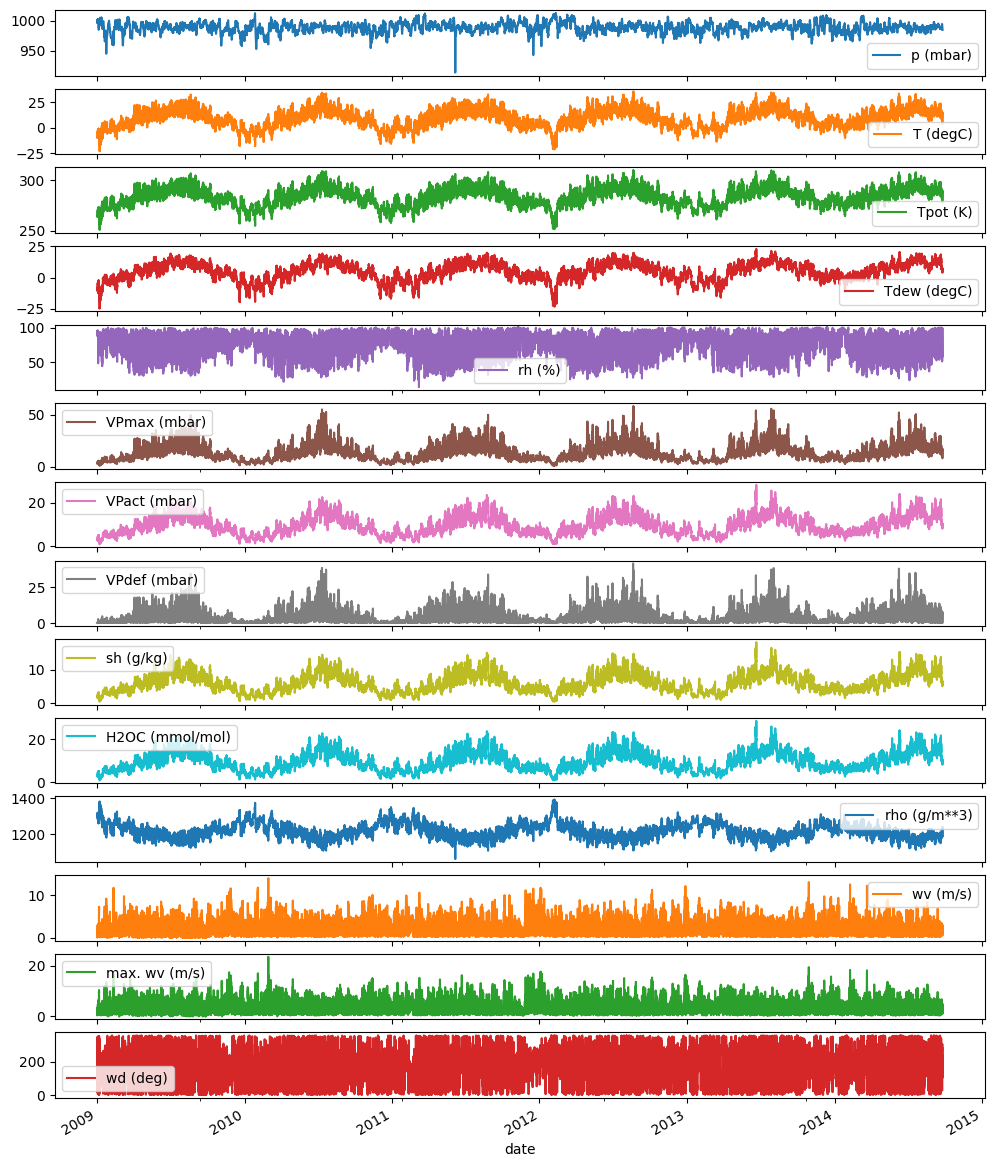

In [89]:
# Dibujemos nuestras variables
cols = data.columns

# N = 24*30*12 # Dibujar 1 año continuo
N = data.shape[0]
plots = data[cols][0:N]
plots.index = data.index[0:N]
_ = plots.plot(subplots=True, figsize=(12,16))

**Observaciones**:

- Las variables tienen diferentes rangos de amplitud. Antes de llevar los datos a la Red LSTM debemos escalarlas/estandarizarlas.
- Al parecer existe un *outlier* en la presión (aproximadamente 950 mbars). Sin embargo este dato es normal, pues la presión puede variar entre 100 y 1.050

### 5.2. Datos faltantes

In [90]:
print('Total NaNs:')
for column in data:
    nans = data[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Total NaNs:
	Columna p (mbar): 0
	Columna T (degC): 0
	Columna Tpot (K): 0
	Columna Tdew (degC): 0
	Columna rh (%): 0
	Columna VPmax (mbar): 8
	Columna VPact (mbar): 0
	Columna VPdef (mbar): 0
	Columna sh (g/kg): 0
	Columna H2OC (mmol/mol): 13
	Columna rho (g/m**3): 6
	Columna wv (m/s): 0
	Columna max. wv (m/s): 0
	Columna wd (deg): 0


Las columnas *VPmax (mbar)*, *H2OC (mmol/mol)* y *rho (g/m**3)* presentan datos faltantes.

### 5.3. Periocidad de la muestra

Es importante garantizar que la periodicidad de las muestras, en nuestro conjunto de datos, es exactamente de 1 hora.

In [91]:
# Verificar si la periodicidad de las muestras es exactamente
# 1 hora (3600 secs)

# Calcular diferencias (en segundos) entre cada par de datos
# consecutivos
df_time_diffs = data.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

date
3600.0    50189
1800.0       61
0.0          24
4200.0        2
4800.0        1
Name: count, dtype: int64


Vemos que:

- 61 pares de registros tienen diferencias de 1.800 s (30 min)
- 24 pares de registros tienen diferencias de 0.0 s
- 2 pares de registros tienen diferencias de 4200 s (1.16 hrs)
- 1 par de registros tiene diferencias de 4.800 s (1.3 hrs)

Deberemos gestionar y corregir este comportamiento.

## 6. Pre-procesamiento

Realizaremos las siguientes tareas:

- Gestión de datos faltantes
- Ajuste de la periodicidad del

### 6.1. Datos faltantes

Dado el reducido número de datos faltantes, podemos usar una simple interpolación para completarlos:

In [92]:
# Interpolación lineal para completar datos faltantes
columns = ['VPmax (mbar)', 'H2OC (mmol/mol)', 'rho (g/m**3)']

for column in columns:
    data[column] = data[column].interpolate(method='linear')

# Verificar que no hay datos faltantes
print('Cantidad de NaNs:')
for column in data:
    nans = data[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna p (mbar): 0
	Columna T (degC): 0
	Columna Tpot (K): 0
	Columna Tdew (degC): 0
	Columna rh (%): 0
	Columna VPmax (mbar): 0
	Columna VPact (mbar): 0
	Columna VPdef (mbar): 0
	Columna sh (g/kg): 0
	Columna H2OC (mmol/mol): 0
	Columna rho (g/m**3): 0
	Columna wv (m/s): 0
	Columna max. wv (m/s): 0
	Columna wd (deg): 0


### 6.2. Ajuste de la periodicidad del dataset

Recordemos los siguientes datos de peiocidad del conjunto de datos:

- 61 pares de registros con diferencias de 1.800 s (30 min)
- 24 pares de registros con diferencias de 0.0 s
- 2 pares de registros con diferencias de 4200 s (1.16 hrs)
- 1 par de registros con diferencias de 4.800 s (1.3 hrs)


Corrijamos los pares de registros con diferencias de 0.0s que son simplemente registros repetidos.

In [93]:
# Eliminar duplicados para corregir el problema de diferencias
# de 0.0 s
data.drop_duplicates(keep='first', inplace=True, ignore_index=False)

# Y verificar que han sido eliminados
df_time_diffs = data.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

date
3600.0    50189
1800.0       61
4200.0        2
4800.0        1
Name: count, dtype: int64


Seguidamente, pasamos a correjir los datos restantes para garantizar que entre pares de datos consecutivos habrá una periodicidad de 1 hora.

Usaremos el método *asfreq* de Pandas. Como aparecerán nuevos datos, usaremos el método *bfill* para rellenar estos nuevos datos.

In [95]:
# Reinterpolar el dataset con una periodicidad de 1 hora
df2 = data.asfreq(freq='h', method='bfill')

# Y verificar que la totalidad del dataset tiene esta periodicidad
df_time_diffs = df2.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

date
3600.0    50223
Name: count, dtype: int64


In [96]:
# Verificar que el dataset resultante no contiene NaNs:
print('Cantidad de NaNs:')
for column in data:
    nans = df2[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna p (mbar): 0
	Columna T (degC): 0
	Columna Tpot (K): 0
	Columna Tdew (degC): 0
	Columna rh (%): 0
	Columna VPmax (mbar): 0
	Columna VPact (mbar): 0
	Columna VPdef (mbar): 0
	Columna sh (g/kg): 0
	Columna H2OC (mmol/mol): 0
	Columna rho (g/m**3): 0
	Columna wv (m/s): 0
	Columna max. wv (m/s): 0
	Columna wd (deg): 0


Finalmente verificar las columnas originales y modificadas para constatar que los valores promedio no cambian.

In [99]:
for column in data:
    print(f'Promedios original/modificado: {data[column].mean():.2f}/{df2[column].mean():.2f}')

Promedios original/modificado: 988.66/988.66
Promedios original/modificado: 9.26/9.25
Promedios original/modificado: 283.35/283.34
Promedios original/modificado: 4.77/4.77
Promedios original/modificado: 76.00/76.02
Promedios original/modificado: 13.47/13.46
Promedios original/modificado: 9.47/9.47
Promedios original/modificado: 4.00/3.99
Promedios original/modificado: 5.98/5.98
Promedios original/modificado: 9.58/9.58
Promedios original/modificado: 1216.29/1216.31
Promedios original/modificado: 2.15/2.15
Promedios original/modificado: 3.55/3.55
Promedios original/modificado: 173.44/173.42


En este punto ya contamos con un dataset íntegro (no contiene datos faltantes ni *outliers* y tiene una periodicidad de 1 hora).

Solo nos resta guardarlo.

In [101]:
path = '/content/Forecasting_weather_with_LSTM/outputs/'
df2.to_csv(path +'weather_dataset_preprocesado.csv')